# CSMODEL S16 MCO1

### Group 12 Members:
- ALBARRACIN, CLARISSA MAMUYAC
- CAPOTE, MARY GRACE SAN PEDRO
- RESURRECCION, ALJIRAH BRENDL YUTAN
- TAMSE, ANDREI GONZALES

The dataset used is [Salaries of Different Data Science Fields in the Data Science Domain](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023/data) and obtained from Kaggle that covers data science salaries from 2020 to 2023. It provides data such as work experience, employment type, job titles, and salaries. Our goal is to explore this dataset and gain insights using data modeling techniques.


Collection Process: Data has been sourced from aijobs.net in April 2023 in https://ai-jobs.net/salaries/  Checking the website, it is internally aggregated from the offered salaries in the job listing along with user reported salaries.
The most recent update is within the ai-jobs.net website, that includes 2024.

Possible Implications of Data Collection Method: The dataset focuses primarily on the United States' salaries in the Data Science domain. This factor may lead to inaccurate conclusions as not all countries are distributed properly. It is unclear whether or not the salaries shown are adjusted for inflation; potentially giving inaccurate salary amounts. Lastly, because the data collection includes self-reported salaries, there is a possibility of false reports, which could render some data invalid.

## Imported Libraries

In [1]:
%pip install pingouin
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
from tabulate import tabulate
from scipy.stats import skew, shapiro, levene, f_oneway, kruskal
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.utils import resample
import pingouin as pg


## Read Dataset

In [3]:
ds_salary_df = pd.read_csv("ds_salaries.csv")
ds_salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [4]:
ds_salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


1. All data types are correct.
2. There are no missing values (null values) present in the dataset.

# Dataset Columns and Descriptions

| Column Name        | Description                                                  |
|--------------------|--------------------------------------------------------------|
| work_year          | The year the salary was paid.                                |
| experience_level   | The experience level in the job during the year with possible values: EN (Entry-level / Junior), MI (Mid-level / Intermediate), SE (Senior-level / Expert), EX (Executive-level / Director). |
| employment_type    | The type of employment for the role with possible values: PT (Part-time), FT (Full-time), CT (Contract), FL (Freelance). |
| job_title          | The role worked in during the year.                          |
| salary             | The total gross salary amount paid. No currency attached.    |
| salary_currency    | The currency of the salary paid as an ISO 4217 currency code.|
| salary_in_usd      | The salary in USD, calculated using statistical data from the BIS and central banks. |
| employee_residence | Employee's primary country of residence during the work year as an ISO 3166 country code. |
| remote_ratio       | The overall amount of work done remotely with possible values: 0 (No remote work), 50 (Partially remote/hybrid), 100 (Fully remote). |
| company_location   | The country of the employer's main office or contracting branch as an ISO 3166 country code. |
| company_size       | The average number of people that worked for the company during the year with possible values: S (less than 50 employees), M (50 to 250 employees), L (more than 250 employees). |


In [5]:
observation_count, variables_count = ds_salary_df.shape

print("Number of observations:", observation_count)
print("Number of variables:", variables_count)

Number of observations: 3755
Number of variables: 11


## Dataset Cleaning

In [6]:
for column in ds_salary_df.columns:
    unique_values = ds_salary_df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'work_year': [2023 2022 2020 2021]
Unique values in column 'experience_level': ['SE' 'MI' 'EN' 'EX']
Unique values in column 'employment_type': ['FT' 'CT' 'FL' 'PT']
Unique values in column 'job_title': ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'M

**Observation columns have unique values and are free from typos. But some job titles have inconsistencies, therefore it is subjected for cleaning.**

In [7]:
# Creating new clean dataset
ds_salary_clean = ds_salary_df

### Generalization of Job Titles

To reduce redundancy and standardize job titles, specific ranks such as "Principal" and "Staff" will be generalized. This is done to align with the existing categorization based on experience levels.

1. **Principal Machine Learning Engineer** ➔ Machine Learning Engineer
2. **Staff Data Analyst** ➔ Data Analyst
3. **Staff Data Scientist** ➔ Data Scientist
4. **Principal Data Architect** ➔ Data Architect
5. **Principal Data Engineer** ➔ Data Engineer
6. **Principal Data Analyst** ➔ Data Analyst
7. **Principal Data Scientist** ➔ Data Scientist


In [8]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'Principal Machine Learning Engineer': 'Machine Learning Engineer',
    'Staff Data Analyst': 'Data Analyst',
    'Staff Data Scientist': 'Data Scientist',
    'Principal Data Architect': 'Data Architect',
    'Principal Data Engineer': 'Data Engineer',
    'Principal Data Analyst': 'Data Analyst',
    'Principal Data Scientist': 'Data Scientist'
})


### Cleaning Duplicated Job Titles

The dataset contains 93 job titles. The dataset's duplicated job listings are cleaned as follows:

1. **ML Engineer** ➔ Machine Learning Engineer (ML is shorthand for Machine Learning)
2. **BI Analyst** ➔  BI Data Analyst (BI = Business Intelligence)
3. **Machine Learning Software Engineer** ➔  Machine Learning Engineer
4. **Lead Data Scientist** ➔ Data Science Lead   

Job titles that appear similar but are not are the following:

1. Data Manager and Data Science Manager
2. BI (Business Intelligence) Data Analyst and Business Data Analyst.

In [9]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'ML Engineer': 'Machine Learning Engineer',
    'BI Analyst': 'BI Data Analyst',
    'Machine Learning Software Engineer': 'Machine Learning Engineer',
    'Lead Data Scientist': 'Data Science Lead'
})

### Cleaning Administrative Job Titles

For easier viewing, all administrative positions (e.g., manager, lead, consultant, director) are placed at the end of the job title.

1. **Director of Data Science** ➔ Data Science Director
2. **Head of Data** ➔ Data Head
3. **Head of Data Science** ➔ Data Science Head
4. **Head of Machine Learning** ➔ Machine Learning Head
5. **Lead Machine Learning Engineer** ➔ Machine Learning Engineer Lead
6. **Lead Data Analyst** ➔ Data Analyst Lead
7. **Lead Data Engineer** ➔ Data Engineer Lead

In [10]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'Director of Data Science': 'Data Science Director',
    'Head of Data': 'Data Head',
    'Head of Data Science': 'Data Science Head',
    'Head of Machine Learning': 'Machine Learning Head',
    'Lead Machine Learning Engineer': 'Machine Learning Engineer Lead',
    'Lead Data Analyst': 'Data Analyst Lead',
    'Lead Data Engineer': 'Data Engineer Lead'
})

## Dataset Preprocessing

### Dropping Unnecessary Variables

We have removed variables that are not required for our analysis.
These variables include:

1. **salary**
2. **salary_currency**
3. **employee_residence**

In [11]:
initial_columns = ds_salary_clean.columns.tolist()

# Drop the 'salary', 'salary_currency', and 'employee_residence' columns
ds_salary_clean.drop(columns=['salary', 'salary_currency', 'employee_residence'], inplace=True)

final_columns = ds_salary_clean.columns.tolist()

print("Columns before and after dropping 'salary' and 'salary_currency':")
print(tabulate([["Initial Columns", ", ".join(initial_columns)],
                ["Final Columns", ", ".join(final_columns)]],
               headers=["Stage", "Columns"], tablefmt="grid"))

Columns before and after dropping 'salary' and 'salary_currency':
+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Stage           | Columns                                                                                                                                                           |
+=================+===================================================================================================================================================================+
| Initial Columns | work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size |
+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Final Column

In [12]:
ds_salary_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         3755 non-null   int64 
 1   experience_level  3755 non-null   object
 2   employment_type   3755 non-null   object
 3   job_title         3755 non-null   object
 4   salary_in_usd     3755 non-null   int64 
 5   remote_ratio      3755 non-null   int64 
 6   company_location  3755 non-null   object
 7   company_size      3755 non-null   object
dtypes: int64(3), object(5)
memory usage: 234.8+ KB


In [13]:
ds_salary_clean.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Scientist,85847,100,ES,L
1,2023,MI,CT,Machine Learning Engineer,30000,100,US,S
2,2023,MI,CT,Machine Learning Engineer,25500,100,US,S
3,2023,SE,FT,Data Scientist,175000,100,CA,M
4,2023,SE,FT,Data Scientist,120000,100,CA,M


## Exploratory Data Analysis

### EDA Questions:
1. What does the salary **(salary_in_usd)** distribution look like?
2. What are the most common company locations represented in the dataset?
3. What are the most common job titles found in the dataset?
4. Is there a correlation between salary and experience level?
5. How does the type of employment affect salary distribution, and which employment type exhibits the greatest salary variability?




### Question 1  - What does the salary **(salary_in_usd)** distribution look like?

**Numerical Summaries:**

In [14]:
# Measures of Central Tendency
mean_salary = ds_salary_clean['salary_in_usd'].mean()
median_salary = ds_salary_clean['salary_in_usd'].median()
mode_salary = ds_salary_clean['salary_in_usd'].mode().values[0]  # In case of multiple modes, take the first one

print(f"Mean salary: ${mean_salary:,.2f}")
print(f"Median salary: ${median_salary:,.2f}")
print(f"Mode salary: ${mode_salary:,.2f}")

# Measures of Dispersion
salary_range = ds_salary_clean['salary_in_usd'].max() - ds_salary_clean['salary_in_usd'].min()
salary_variance = ds_salary_clean['salary_in_usd'].var()
salary_std = ds_salary_clean['salary_in_usd'].std()

print(f"Salary range: ${salary_range:,.2f}")
print(f"Salary variance: ${salary_variance:,.2f}")
print(f"Salary standard deviation: ${salary_std:,.2f}")

# Compute correlation matrix for selected numeric columns
numeric_columns = ['salary_in_usd']
numeric_df = ds_salary_clean[numeric_columns]



Mean salary: $137,570.39
Median salary: $135,000.00
Mode salary: $100,000.00
Salary range: $444,868.00
Salary variance: $3,976,011,879.23
Salary standard deviation: $63,055.63


**Central Tendency:** The mean salary of $137,570.39, median salary of $135,000.00, and mode salary of $100,000.00 indicate that salaries cluster around these values, highlighting typical salary levels in the dataset.

**Dispersion:** A wide salary range of $444,868.00, large variance of $3,976,011,879.23, and standard deviation of $63,055.63 illustrate significant variability in salary levels, reflecting diverse income ranges within the dataset.


**Visualization:**

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


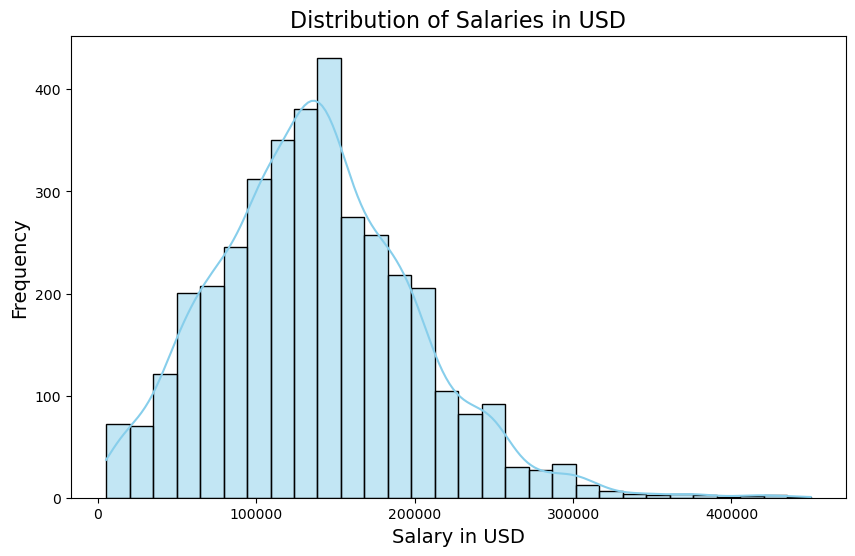

The skewness of the salary distribution is: 0.54


In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(ds_salary_clean['salary_in_usd'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of Salaries in USD', fontsize=16)
plt.xlabel('Salary in USD', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

# Skewness of salary_in_usd
salary_data = ds_salary_clean['salary_in_usd']
salary_skewness = skew(salary_data)

print(f"The skewness of the salary distribution is: {salary_skewness:.2f}")


The skewness of the salary distribution is 0.54, indicating a **moderately positively skewed distribution**.  Because of this skewness, some higher salaries have pulled the mean to the right, making the mean salary slightly higher than the median. For most data points, the median provides a better indication of the central tendency than the mode, which is likely lower. This indicates that while there are enough higher wages to produce a moderate positive skew, the majority of pay data points appear to be clustered around a central value.

### Question 2  - What are the most common company locations represented in the dataset?


**Numerical Summaries:**

In [16]:
most_common_location = ds_salary_clean['company_location'].mode()[0]
count_most_common_location = ds_salary_clean['company_location'].value_counts().max()

print("Most common company location:", most_common_location)
print("Count of the most common location:", count_most_common_location)

num_unique_locations = len(ds_salary_clean['company_location'].unique())
print("Number of unique company locations:", num_unique_locations)

company_location_counts = ds_salary_clean['company_location'].value_counts()
company_location_percentages = ds_salary_clean['company_location'].value_counts(normalize=True) * 100

print("\nCompany Location Counts:")
print(company_location_counts)
print("\nCompany Location Percentages:")
print(company_location_percentages)

Most common company location: US
Count of the most common location: 3040
Number of unique company locations: 72

Company Location Counts:
company_location
US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
MK       1
BS       1
IR       1
CR       1
MT       1
Name: count, Length: 72, dtype: int64

Company Location Percentages:
company_location
US    80.958722
GB     4.580559
CA     2.316911
ES     2.050599
IN     1.544607
        ...    
MK     0.026631
BS     0.026631
IR     0.026631
CR     0.026631
MT     0.026631
Name: proportion, Length: 72, dtype: float64


**Visualization:**

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


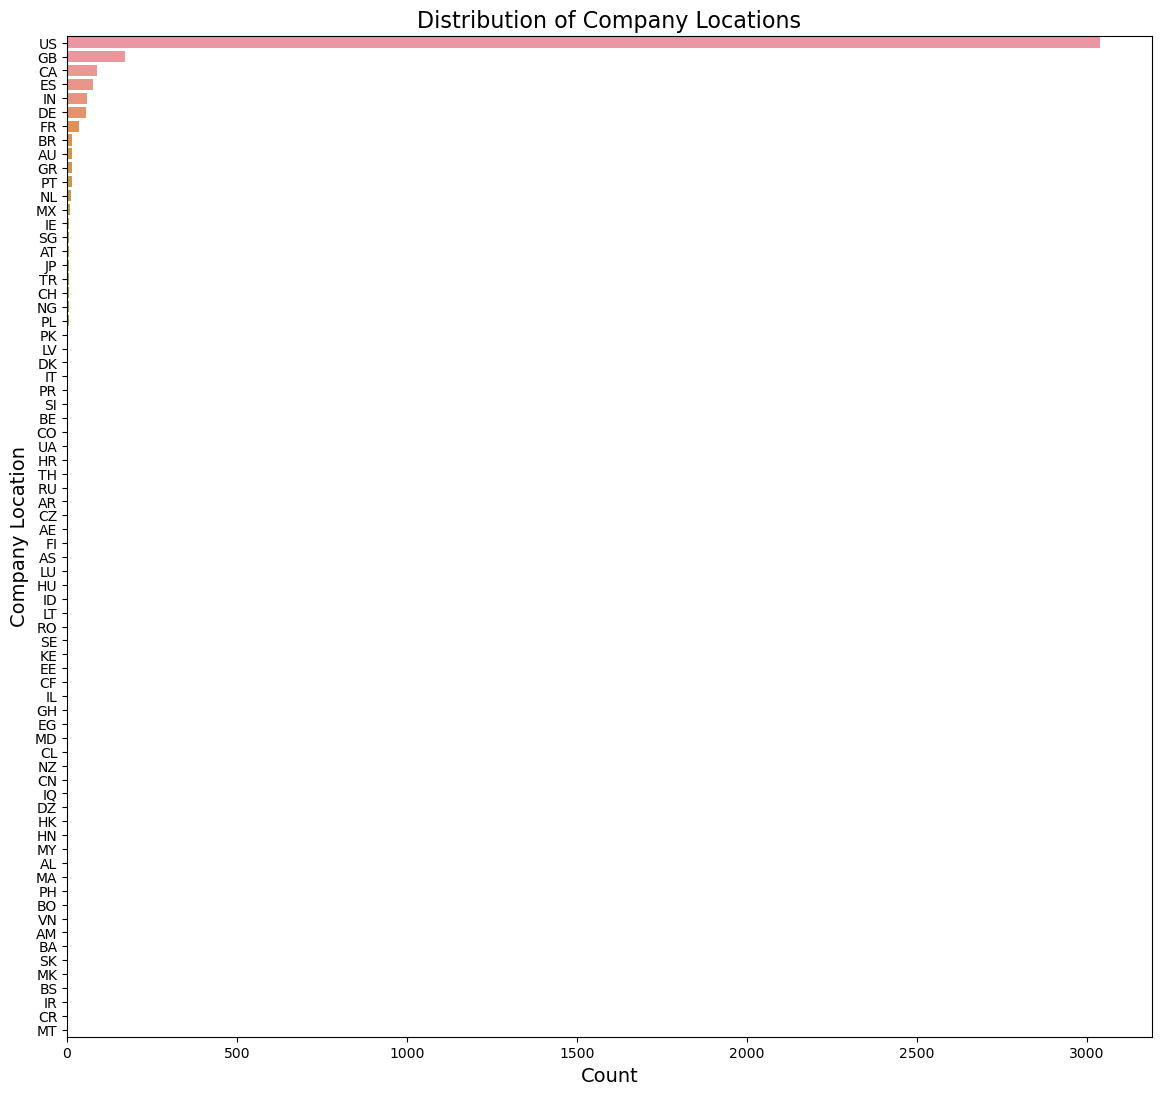

In [17]:
plt.figure(figsize=(14, 13))
sns.countplot(y='company_location', data=ds_salary_clean, order=ds_salary_clean['company_location'].value_counts().index)
plt.title('Distribution of Company Locations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Company Location', fontsize=14)
plt.show()

The analysis of the **company_location** variable indicates a **bias** towards  the United States market, which hosts the majority of companies in the dataset (3040 out of 3755 observations, or approximately 80.96%). This bias suggests that the dataset may not fully represent global diversity in company locations and could skew insights towards regions with higher data availability or participation.

### Question 3 - What are the most common job titles found in the dataset?

**Numerical Summaries:**

In [18]:
most_common_title = ds_salary_clean['job_title'].mode()[0]
count_most_common_title = ds_salary_clean['job_title'].value_counts().max()

print("Most common job title:", most_common_title)
print("Count of the most common job title:", count_most_common_title)

num_unique_titles = len(ds_salary_clean['job_title'].unique())
print("Number of unique job titles:", num_unique_titles)

job_title_counts = ds_salary_clean['job_title'].value_counts()
job_title_percentages = ds_salary_clean['job_title'].value_counts(normalize=True) * 100

print("\nJob Title Counts:")
print(job_title_counts)
print("\nJob Title Percentages:")
print(job_title_percentages)

Most common job title: Data Engineer
Count of the most common job title: 1042
Number of unique job titles: 82

Job Title Counts:
job_title
Data Engineer                 1042
Data Scientist                 849
Data Analyst                   615
Machine Learning Engineer      334
Analytics Engineer             103
                              ... 
Data Management Specialist       1
Deep Learning Researcher         1
Manager Data Management          1
Azure Data Engineer              1
Finance Data Analyst             1
Name: count, Length: 82, dtype: int64

Job Title Percentages:
job_title
Data Engineer                 27.749667
Data Scientist                22.609854
Data Analyst                  16.378162
Machine Learning Engineer      8.894807
Analytics Engineer             2.743009
                                ...    
Data Management Specialist     0.026631
Deep Learning Researcher       0.026631
Manager Data Management        0.026631
Azure Data Engineer            0.026631
Fina

**Visualization:**

Text(0.5, 1.0, 'Top 20 Job Titles')

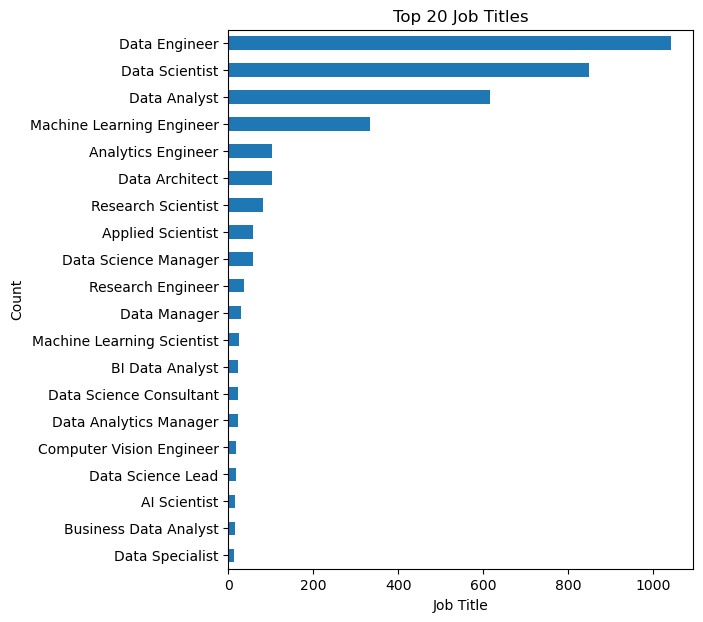

In [19]:
top20_job_title_count_df = job_title_counts.head(20)
top20_job_title_count_df.plot.barh(figsize=(6,7)).invert_yaxis()
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Top 20 Job Titles')

Analysis on the job_title variable shows that the three job titles with the most observations are Data Engineer, Data Scientist, and Data Analyst respectively. Visualizations are also limited to show only the top 20 job titles present due to the large number of unique job titles (82 unique job titles). Due to numerous job titles being underrepresented, the dataset may not properly show the full spectrum of roles within the Data Science field.

### Question 4  - Is there a correlation between salary and experience level?

**Numerical Summaries:**

In [20]:
# Group data by 'experience_level' and calculate summary statistics
summary_stats = ds_salary_clean.groupby('experience_level')['salary_in_usd'].agg(['mean', 'median', 'std', 'min', 'max'])
print(summary_stats)

                           mean    median           std    min     max
experience_level                                                      
EN                 78546.284375   70000.0  52225.424309   5409  300000
EX                194930.929825  196000.0  70661.929661  15000  416000
MI                104525.939130  100000.0  54387.685128   5132  450000
SE                153051.071542  146000.0  56896.263954   8000  423834


* **EN (Entry-level / Junior):**
    * Mean: $78,546.28
    * Median: $70,000.00
    * Std: $52,225.42
    * Min: $5,409
    * Max: $300,000
* **EX (Executive-level / Director):**
    * Mean: $194,930.93
    * Median: $196,000.00
    * Std: $70,661.93
    * Min: $15,000
    * Max: $416,000
* **MI (Mid-level / Intermediate):**
    * Mean: $104,525.94
    * Median: $100,000.00
    * Std: $54,387.69
    * Min: $5,132
    * Max: $450,000
* **SE (Senior-level / Expert):**
    * Mean: $153,051.07
    * Median: $146,000.00
    * Std: $56,896.26
    * Min: $8,000
    * Max: $423,834

**Visualization:**

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


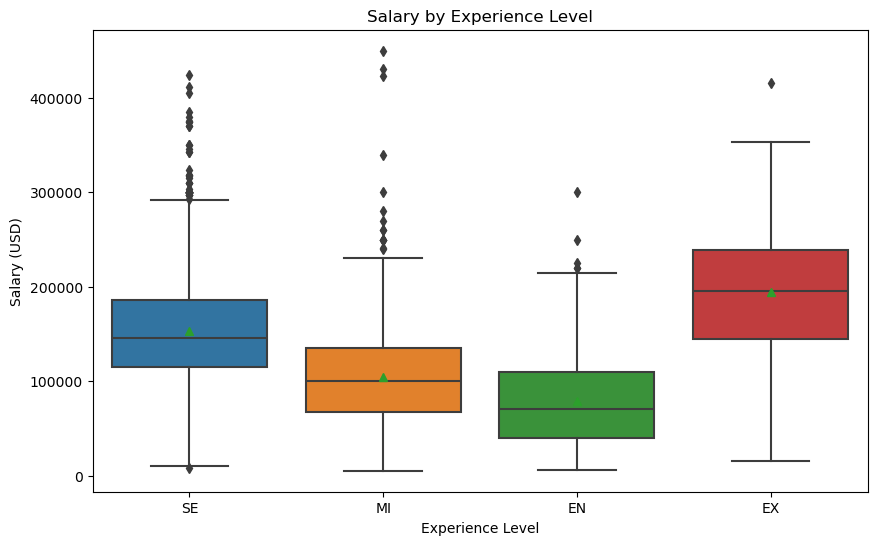

In [21]:
# Salary vs. Experience Level
plt.figure(figsize=(10,6))
sns.boxplot(
    x = "experience_level",
    y = "salary_in_usd",
    showmeans=True,
    data=ds_salary_clean
)
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')
plt.title('Salary by Experience Level')
plt.show()

Based on the trend observed from the box plot suggests that as the **experience level** increases, so does the the **salary** and the range of potential salaries. Implicating that there is a positive correlation between the two variables.

### Question 5 - How does the type of employment affect salary distribution, and which employment type exhibits the greatest salary variability?

**Numerical Summaries:**

In [22]:
# Group data by 'employment_type' and calculate summary statistics
summary_stats = ds_salary_clean.groupby('employment_type')['salary_in_usd'].agg(['mean', 'median', 'std', 'min', 'max'])
print(summary_stats)

                          mean    median            std    min     max
employment_type                                                       
CT               113446.900000   75000.0  130176.746842   7500  416000
FL                51807.800000   50000.0   29458.879336  12000  100000
FT               138314.199570  135000.0   62452.177613   5132  450000
PT                39533.705882   21669.0   38312.145181   5409  125404


**Visualization:**

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


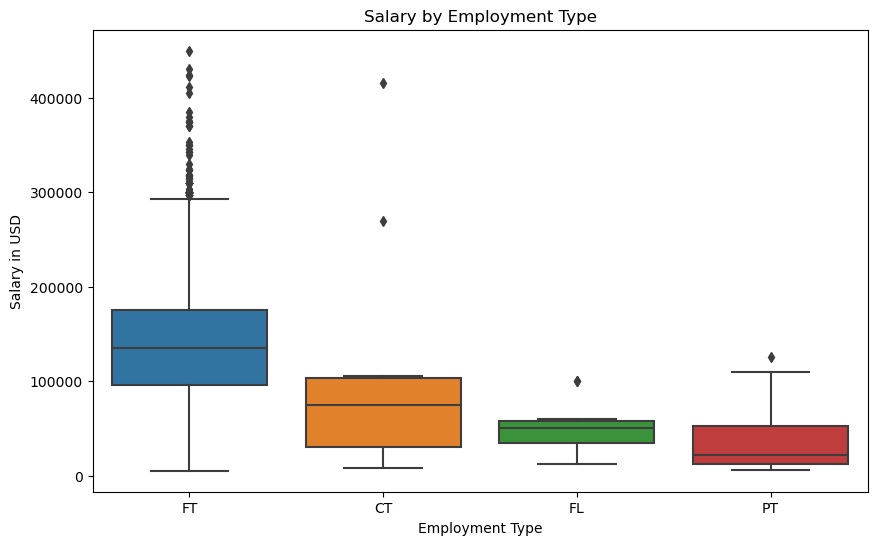

In [23]:
# Box Plot for salary and employment type
plt.figure(figsize=(10, 6))
sns.boxplot(data=ds_salary_clean, x='employment_type', y='salary_in_usd')

plt.title('Salary by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Salary in USD')
plt.show()

This box plot analysis aims to compare the **salary** ranges from different **employment types**, suggesting that there is a difference in financial growth potential for each category.

* **Contract (CT):** Shows a high mean salary but also a large standard deviation, indicating a wide range of salaries. The maximum salary is substantial, suggesting good growth potential for high-skilled positions.

* **Consulting (CL):** Has a lower mean salary compared to CT, with less variability. The growth potential may be moderate, with salaries mostly clustered around the median.

* **Freelance (FL):** Exhibits the highest mean salary and maximum salary, indicating excellent growth potential, especially for top performers in their field.

* **Part-Time (PT):** Has the lowest mean and maximum salaries, reflecting limited growth potential, likely due to fewer hours worked.

## Research Question

An in-depth exploratory data analysis (EDA) enabled us to better comprehend and visualize our dataset. We began by evaluating a detailed dataset of employment categories, experience levels, job titles, work, company location, and salaries. By carefully researching and visualizing the data, we discovered trends in how salaries fluctuate across different categories. This helped us comprehend the complex structures of salary distribution.

Our exploratory data analysis has led us to a key research question:  
**What combinations of factors are most strongly associated with high salaries in the United States' job market?**

This study aims to uncover the key determinants of high salaries in the data industry by identifying the most influential combinations of factors. It can help discover patterns and inequalities in wage structures, allowing businesses and employees to make more informed decisions about salary negotiations, career advancement, and talent retention. Furthermore, this research subject is timely in today's technological age, as data-driven decision-making is becoming increasingly important to corporate operations. As the demand for qualified data professionals grows, understanding the nuanced factors influencing wages becomes critical for businesses looking to recruit and retain the best employees. Similarly, findings from this research might help workers navigate their careers in the data business by informing strategic decisions about career routes and compensation expectations, ultimately leading to a more equal and competitive employment market.

## Data Modelling

### A. Preprocessing

#### Dropping all Non-US companies

As the study focuses specifically in the information from the United States' job market, all records from non-US companies are dropped. The ISO 3166 code for the United States will be utilized for this step (US).

In [24]:
ds_us_salary_clean = ds_salary_clean[ds_salary_clean['company_location'] == 'US']
ds_us_salary_clean.shape

(3040, 8)

#### B. Binning Salary Values

As discovered from the Exploratory Data Analysis, the salaries found in the dataset is highly varied and specific. It is also observed that the salary distribution is moderately positively skewed. To better interpret results from the data modelling process while ensuring each category has a significant number of data points, these values will be categorized using the **Quantile Binning** technique into **five classes**: 
* **Very Low**
* **Low**
* **Moderate**
* **High**
* **Very High**



In [25]:
ds_us_salary_clean = ds_us_salary_clean.copy()

labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

ds_us_salary_clean.loc[:, 'salary_bin'] = pd.qcut(ds_us_salary_clean['salary_in_usd'], q=5, labels=labels)

print(ds_us_salary_clean.sort_values(by='salary_in_usd')[['salary_in_usd', 'salary_bin']])

      salary_in_usd salary_bin
3667           5679   Very Low
3735          12000   Very Low
2378          12000   Very Low
3536          12000   Very Low
2703          20000   Very Low
...             ...        ...
3463         405000  Very High
3750         412000  Very High
3675         416000  Very High
3747         423000  Very High
3522         450000  Very High

[3040 rows x 2 columns]


In [26]:
very_low_count = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == 'Very Low'].shape[0]
print(f"Count of Very Low salaries: {very_low_count}")

low_count = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == 'Low'].shape[0]
print(f"Count of Low salaries: {low_count}")

moderate_count = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == 'Moderate'].shape[0]
print(f"Count of Moderate salaries: {moderate_count}")

high_count = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == 'High'].shape[0]
print(f"Count of High salaries: {high_count}")

very_high_count = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == 'Very High'].shape[0]
print(f"Count of Very High salaries: {very_high_count}")

Count of Very Low salaries: 609
Count of Low salaries: 613
Count of Moderate salaries: 602
Count of High salaries: 613
Count of Very High salaries: 603


In [27]:
bin_edges = ds_us_salary_clean['salary_bin'].cat.categories

# Getting the upper, middle, and lower values for each bin
bin_summary = []
for bin in bin_edges:
    bin_data = ds_us_salary_clean[ds_us_salary_clean['salary_bin'] == bin]['salary_in_usd']
    lower = format(bin_data.min(), ".2f")
    upper = format(bin_data.max(), ".2f")
    middle = format(bin_data.mean(), ".2f")
    bin_summary.append({'Bin': bin, 'Lower': lower, 'Middle': middle, 'Upper': upper})

bin_summary_df = pd.DataFrame(bin_summary)
print(bin_summary_df)

         Bin      Lower     Middle      Upper
0   Very Low    5679.00   82221.04  105500.00
1        Low  105700.00  120783.53  134000.00
2   Moderate  134024.00  145242.76  159699.00
3       High  159832.00  175479.32  195000.00
4  Very High  195400.00  236187.45  450000.00


In [28]:
for column in ds_us_salary_clean.columns:
    print(f"Value counts for column '{column}':")
    print(ds_us_salary_clean[column].value_counts())
    print()  # Print a new line for better readability

# Total row count of the entire DataFrame
total_rows = len(ds_us_salary_clean)
print(f"Total number of rows: {total_rows}")

Value counts for column 'work_year':
work_year
2023    1570
2022    1339
2021     100
2020      31
Name: count, dtype: int64

Value counts for column 'experience_level':
experience_level
SE    2262
MI     497
EN     183
EX      98
Name: count, dtype: int64

Value counts for column 'employment_type':
employment_type
FT    3022
CT       8
PT       6
FL       4
Name: count, dtype: int64

Value counts for column 'job_title':
job_title
Data Engineer                        909
Data Scientist                       679
Data Analyst                         526
Machine Learning Engineer            253
Data Architect                        97
                                    ... 
Data Science Tech Lead                 1
Manager Data Management                1
Applied Machine Learning Engineer      1
BI Data Engineer                       1
Cloud Data Engineer                    1
Name: count, Length: 61, dtype: int64

Value counts for column 'salary_in_usd':
salary_in_usd
150000    96
100000 

#### B. Association Rules (salary_bin -> remote_ratio)

In [29]:
remote_ratio_counts = ds_us_salary_clean['remote_ratio'].value_counts()

# Print the counts
print("Count of each remote ratio value:")
print(remote_ratio_counts)

Count of each remote ratio value:
remote_ratio
0      1669
100    1331
50       40
Name: count, dtype: int64


Due to the **significant imbalance** in `remote_ratio` values—where `0` has **1669 samples**, `100` has **1331 samples**, and `50` has only **40 samples**—directly applying association rules to the relationship between `salary_bin` and `remote_ratio` can lead to **skewed results**. The **minority class** (`remote_ratio` 50) is underrepresented, which can distort the analysis.

To address this issue, we will **balance the dataset** by using the median count of the `remote_ratio` values. This approach allows us to **equalize the representation** of all categories to a more balanced level. By applying median-based resampling, we aim to achieve **more accurate** and **reliable association rules**, ensuring that the insights derived from the analysis are **robust** and reflective of the true data patterns, without the distortions that could arise from extreme imbalance.


In [30]:
middle_value = int(remote_ratio_counts.median())

df_majority_0 = ds_us_salary_clean[ds_us_salary_clean.remote_ratio == 0]
df_majority_100 = ds_us_salary_clean[ds_us_salary_clean.remote_ratio == 100]
df_minority_50 = ds_us_salary_clean[ds_us_salary_clean.remote_ratio == 50]

df_majority_0_resampled = resample(df_majority_0, 
                                   replace=False,  
                                   n_samples=middle_value,  
                                   random_state=123)  

df_majority_100_resampled = resample(df_majority_100, 
                                     replace=False,  
                                     n_samples=middle_value,
                                     random_state=123)

df_minority_50_resampled = resample(df_minority_50, 
                                    replace=True,  
                                    n_samples=middle_value,  
                                    random_state=123) 

ds_us_salary_balanced = pd.concat([df_majority_0_resampled, df_majority_100_resampled, df_minority_50_resampled])

# Binning salary and converting remote_ratio to categorical
ds_us_salary_balanced['salary_bin'] = pd.qcut(ds_us_salary_balanced['salary_in_usd'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])
ds_us_salary_balanced['remote_ratio'] = ds_us_salary_balanced['remote_ratio'].astype('category')

# One-hot encode remote_ratio and salary_bin
one_hot = pd.get_dummies(ds_us_salary_balanced[['remote_ratio', 'salary_bin']])
onehot = one_hot.astype(bool)

min_support_value = 0.05
min_threshold_value = 0.35

frequent_itemsets = apriori(onehot, min_support=min_support_value, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold_value)
top_rules = rules.sort_values('lift', ascending=False).head()

pd.set_option('display.max_rows', None)
print("Initial number of rules found:", len(rules))
if len(rules) > 0:
    print("\nAll association rules:")
    print(rules.to_string())


Initial number of rules found: 7

All association rules:
              antecedents         consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction  zhangs_metric
0   (salary_bin_Moderate)    (remote_ratio_0)            0.208866            0.333333  0.075131    0.359712  1.079137  0.005510    1.041199       0.092694
1       (salary_bin_High)    (remote_ratio_0)            0.192086            0.333333  0.076133    0.396349  1.189048  0.012105    1.104392       0.196792
2  (salary_bin_Very High)    (remote_ratio_0)            0.198848            0.333333  0.071124    0.357683  1.073048  0.004842    1.037908       0.084972
3   (salary_bin_Very Low)   (remote_ratio_50)            0.214375            0.333333  0.097921    0.456776  1.370327  0.026463    1.227240       0.343990
4        (salary_bin_Low)   (remote_ratio_50)            0.185825            0.333333  0.076384    0.411051  1.233154  0.014442    1.131960       0.232224
5       (sala

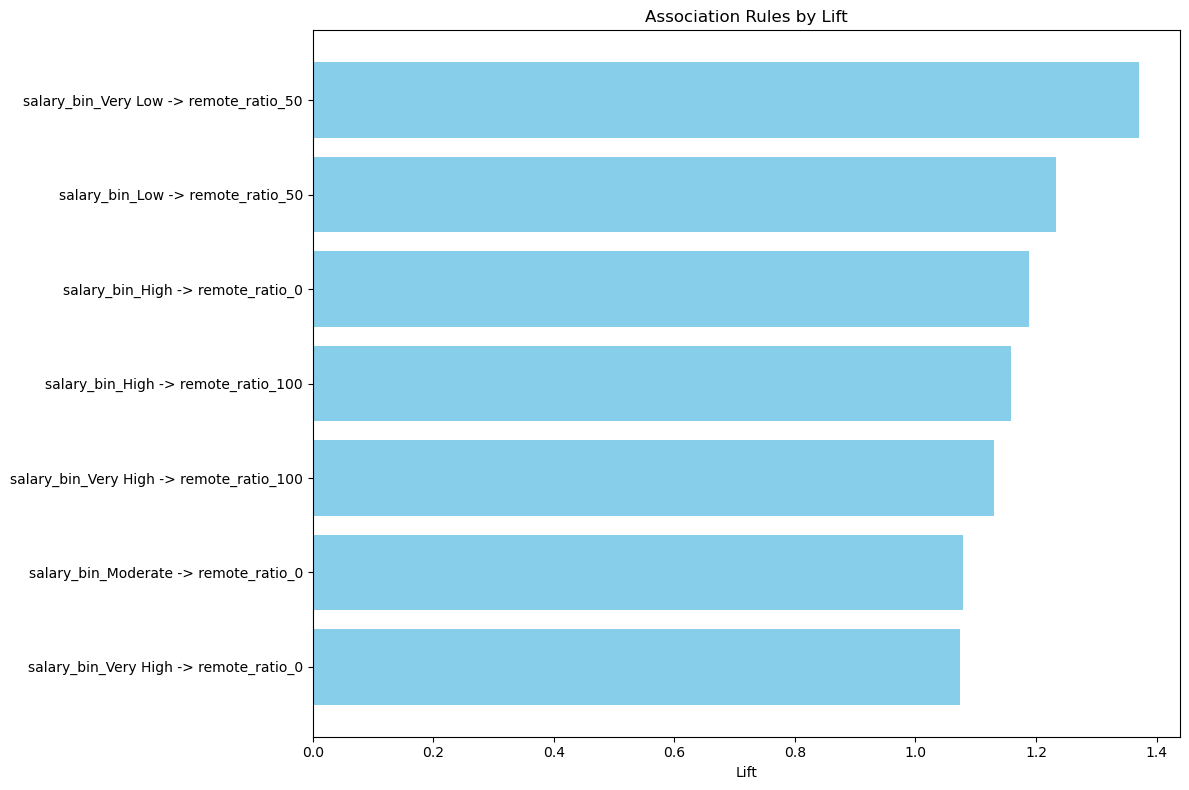

In [31]:
sorted_rules = rules.sort_values('lift', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_rules)), sorted_rules['lift'], color='skyblue')
rule_labels = [f'{list(x)[0]} -> {list(y)[0]}' for x, y in zip(sorted_rules['antecedents'], sorted_rules['consequents'])]

plt.yticks(range(len(sorted_rules)), rule_labels)
plt.xlabel('Lift')
plt.title('Association Rules by Lift')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

The association rules reveal distinct patterns between salary bins and remote work preferences:

- Individuals in the **`Moderate`** and **`High salary bins`** are more likely to have **`0% remote work`**, with confidence levels of **35.9%** and **39.6%**, respectively.
- Those in the **`Very Low`** and **`Low salary bins`** are more inclined towards a **`hybrid setup`** (**`50% remote work`**), with confidence levels of **45.7%** and **41.1%**.
- The **`High salary bin`** shows a notable association with **`100% remote work`**, having a confidence level of **38.6%**.
- The **`Very High salary bin`** shows weaker associations with all remote work categories, with confidence levels ranging from **35.8%** to **37.7%**.

Overall, the rules suggest that individuals with lower salaries are more likely to have a hybrid work setup, while those with higher salaries are more likely to have either no remote work or fully remote work.


#### C. Association Rules (salary_bin -> company_size)

In [32]:
company_size_counts = ds_us_salary_balanced['company_size'].value_counts()
print(company_size_counts)


company_size
M    2518
L    1191
S     284
Name: count, dtype: int64


Since the distribution of **`company size`** is also skewed, we will apply the same balancing principle used for the **`remote ratio`**. This approach will help ensure **more accurate** and **reliable association rules** by correcting the imbalance in the data.


In [33]:

middle_value = int(company_size_counts.mean())


df_medium = ds_us_salary_balanced[ds_us_salary_balanced['company_size'] == 'M']
df_large = ds_us_salary_balanced[ds_us_salary_balanced['company_size'] == 'L']
df_small = ds_us_salary_balanced[ds_us_salary_balanced['company_size'] == 'S']

df_medium_balanced = resample(df_medium,
                              replace=True,
                              n_samples=middle_value,
                              random_state=123)

df_large_balanced = resample(df_large,
                             replace=True,
                             n_samples=middle_value,
                             random_state=123)

df_small_balanced = resample(df_small,
                             replace=True,
                             n_samples=middle_value,
                             random_state=123)

ds_us_salary_balanced = pd.concat([df_medium_balanced, df_large_balanced, df_small_balanced])

# One-hot encode salary_bin, remote_ratio, and company_size
one_hot = pd.get_dummies(ds_us_salary_balanced[['salary_bin', 'company_size']])
onehot = one_hot.astype(bool)

min_support_value = 0.05
min_threshold_value = 0.4

frequent_itemsets = apriori(onehot, min_support=min_support_value, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold_value)

print("Initial number of rules found:", len(rules))
if len(rules) > 0:
    print("\nAll association rules:")
    print(rules.sort_values('lift', ascending=False).to_string())

Initial number of rules found: 8

All association rules:
              antecedents       consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction  zhangs_metric
2   (salary_bin_Moderate)  (company_size_L)            0.157776            0.333333  0.086401    0.547619  1.642857  0.033809    1.473684       0.464608
1        (salary_bin_Low)  (company_size_S)            0.249186            0.333333  0.131981    0.529648  1.588945  0.048919    1.417379       0.493666
6  (salary_bin_Very High)  (company_size_L)            0.145755            0.333333  0.073128    0.501718  1.505155  0.024543    1.337931       0.392881
7  (salary_bin_Very High)  (company_size_M)            0.145755            0.333333  0.068119    0.467354  1.402062  0.019534    1.251613       0.335694
3   (salary_bin_Moderate)  (company_size_M)            0.157776            0.333333  0.070624    0.447619  1.342857  0.018032    1.206897       0.303149
5       (salary_bin_High)

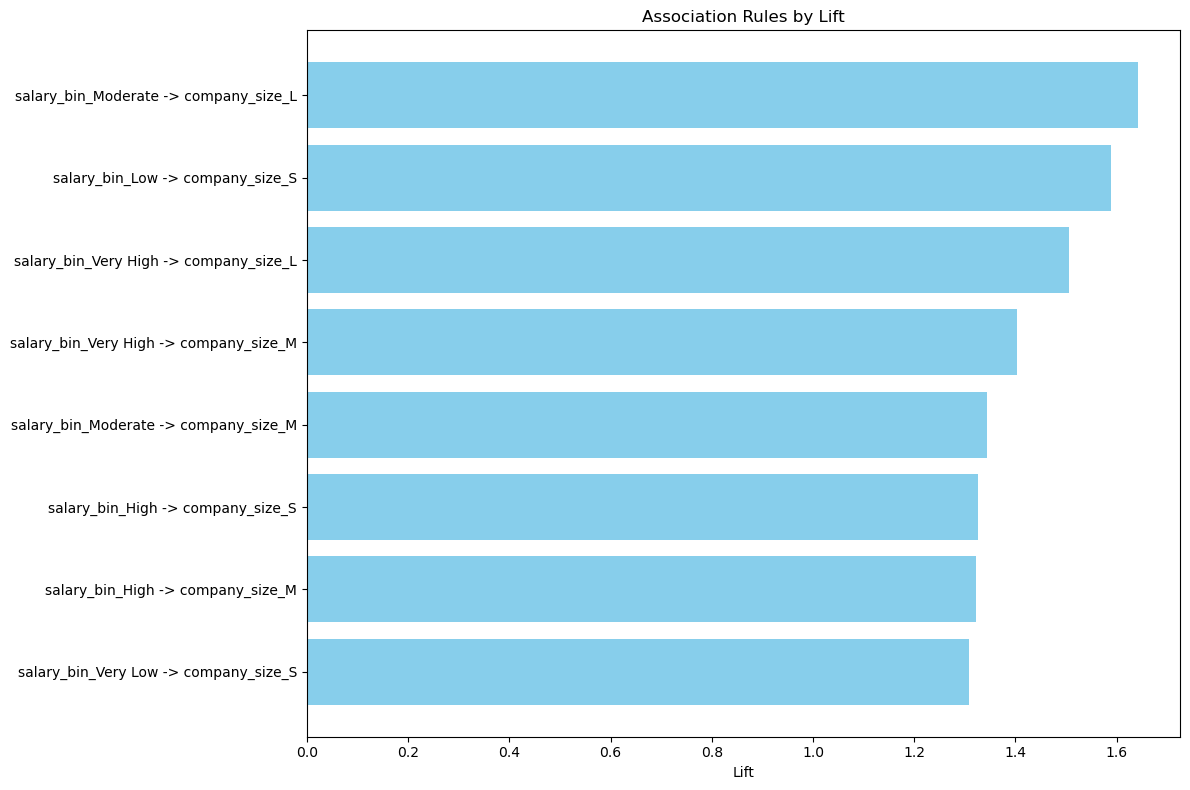

In [34]:
sorted_rules = rules.sort_values('lift', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_rules)), sorted_rules['lift'], color='skyblue')
rule_labels = [f'{list(x)[0]} -> {list(y)[0]}' for x, y in zip(sorted_rules['antecedents'], sorted_rules['consequents'])]

plt.yticks(range(len(sorted_rules)), rule_labels)
plt.xlabel('Lift')
plt.title('Association Rules by Lift')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

The association rules reveal distinct patterns between salary bins and company sizes:

- Individuals in the **`Moderate salary bin`** are most frequently associated with **`Large companies`**, with a confidence of **54.8%**. They are also linked to **`Medium companies`**, with a confidence of **44.8%**.
- Employees in the **`Low salary bin`** are significantly more likely to work for **`Small companies`**, with a confidence of **52.9%**.
- Those in the **`Very High salary bin`** show a notable association with **`Large companies`** and **`Medium companies`**, with confidence levels of **50.2%** and **46.7%**, respectively.
- The **`High salary bin`** shows a tendency towards **`Small companies`** and **`Medium companies`**, with confidence levels of **44.2%** and **42.8%**, respectively.
- Individuals in the **`Very Low salary bin`** are more likely to work for **`Small companies`**, with a confidence of **43.5%**.

Overall, the rules suggest that lower salaries are more common in small companies, while moderate to very high salaries are more frequently found in medium to large companies.


#### D. Association Rules (salary_bin -> job_title)

In [37]:
job_title_counts = ds_us_salary_balanced['job_title'].value_counts()
print(job_title_counts)

job_title
Data Scientist                              792
Data Analyst                                586
Machine Learning Engineer                   527
Data Engineer                               465
Machine Learning Scientist                  252
BI Data Analyst                             229
Data Engineer Lead                          177
Data Science Lead                           150
Research Scientist                          141
Analytics Engineer                          109
Data Science Manager                         75
Business Data Analyst                        70
Applied Machine Learning Scientist           65
Cloud Data Architect                         52
Data Architect                               44
Financial Data Analyst                       36
Applied Scientist                            35
Data Science Tech Lead                       27
Data Analytics Manager                       13
Computer Vision Engineer                     13
AI Scientist                  

The high specificity of job titles becomes a problem as some titles are underrepresented with others overpowering the dataset. We address the skewed distribution of job titles by grouping similar roles and filtering out low-frequency entries. This preprocessing step balances the dataset, reducing bias and improving the reliability of our analysis.

In [56]:
grouped_job_titles = {
    'Data Science': ['Data Scientist', 'Data Science Lead', 'Data Science Manager', 'Data Science Tech Lead', 'Data Science Head', 'Data Head', 'Data Science Consultant', 'Applied Data Scientist', 'Data Science Director', 'Data Science Engineer'],
    'Data Engineering': ['Data Engineer', 'Data Engineer Lead', 'Cloud Data Architect', 'Cloud Database Engineer', 'Data Architect', 'Data Infrastructure Engineer', 'Cloud Data Engineer', 'ETL Developer', 'Big Data Engineer'],
    'Machine Learning': ['Machine Learning Engineer', 'Machine Learning Scientist', 'Applied Machine Learning Scientist', 'AI Scientist', 'Machine Learning Infrastructure Engineer', 'Machine Learning Researcher', 'Machine Learning Manager', 'Machine Learning Developer', 'Deep Learning Engineer'],
    'Analytics': ['Data Analyst', 'Data Analyst Lead', 'BI Data Analyst', 'Analytics Engineer', 'Business Data Analyst', 'Financial Data Analyst', 'Data Analytics Manager', 'Data Analytics Consultant', 'Data Analytics Engineer', 'BI Developer', 'Business Intelligence Engineer'],
    'Research': ['Research Scientist', 'Research Engineer', 'Applied Scientist'],
    'Specialized': ['Computer Vision Engineer', 'Computer Vision Software Engineer', 'NLP Engineer', 'MLOps Engineer'],
    'Data Operations': ['Data Operations Engineer', 'Data Operations Analyst', 'Data Manager', 'Data Specialist', 'Data Lead', 'Manager Data Management']
}

ds_us_salary_balanced['job_category'] = ds_us_salary_balanced['job_title'].map({title: category for category, titles in grouped_job_titles.items() for title in titles})

print("Before filtering:")
print(ds_us_salary_balanced['job_category'].value_counts())

# frequency-based filtering
min_threshold = 100
ds_us_salary_balanced_filtered = ds_us_salary_balanced[ds_us_salary_balanced.groupby('job_category')['job_title'].transform('count') >= min_threshold] 

print()
print("After filtering:")
print(ds_us_salary_balanced_filtered['job_category'].value_counts())

# One-hot encode salary_bin and job_category
one_hot = pd.get_dummies(ds_us_salary_balanced_filtered[['salary_bin', 'job_category']])
onehot = one_hot.astype(bool)

min_support_value = 0.05
min_threshold_value = 0.4

frequent_itemsets = apriori(onehot, min_support=min_support_value, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold_value)

print()
print("Initial number of rules found:", len(rules))
if len(rules) > 0:
    print("\nAll association rules:")
    print(rules.sort_values('lift', ascending=False).to_string())


Before filtering:
job_category
Analytics           1071
Data Science        1070
Machine Learning     865
Data Engineering     752
Research             186
Specialized           27
Data Operations       22
Name: count, dtype: int64

After filtering:
job_category
Analytics           1071
Data Science        1070
Machine Learning     865
Data Engineering     752
Research             186
Name: count, dtype: int64

Initial number of rules found: 4

All association rules:
                       antecedents                      consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction  zhangs_metric
2                (salary_bin_High)  (job_category_Data Engineering)            0.188895            0.190669  0.080629    0.426846  2.238669  0.044612    1.412064       0.682163
3  (job_category_Data Engineering)                (salary_bin_High)            0.190669            0.188895  0.080629    0.422872  2.238669  0.044612    1.405418       0.6836

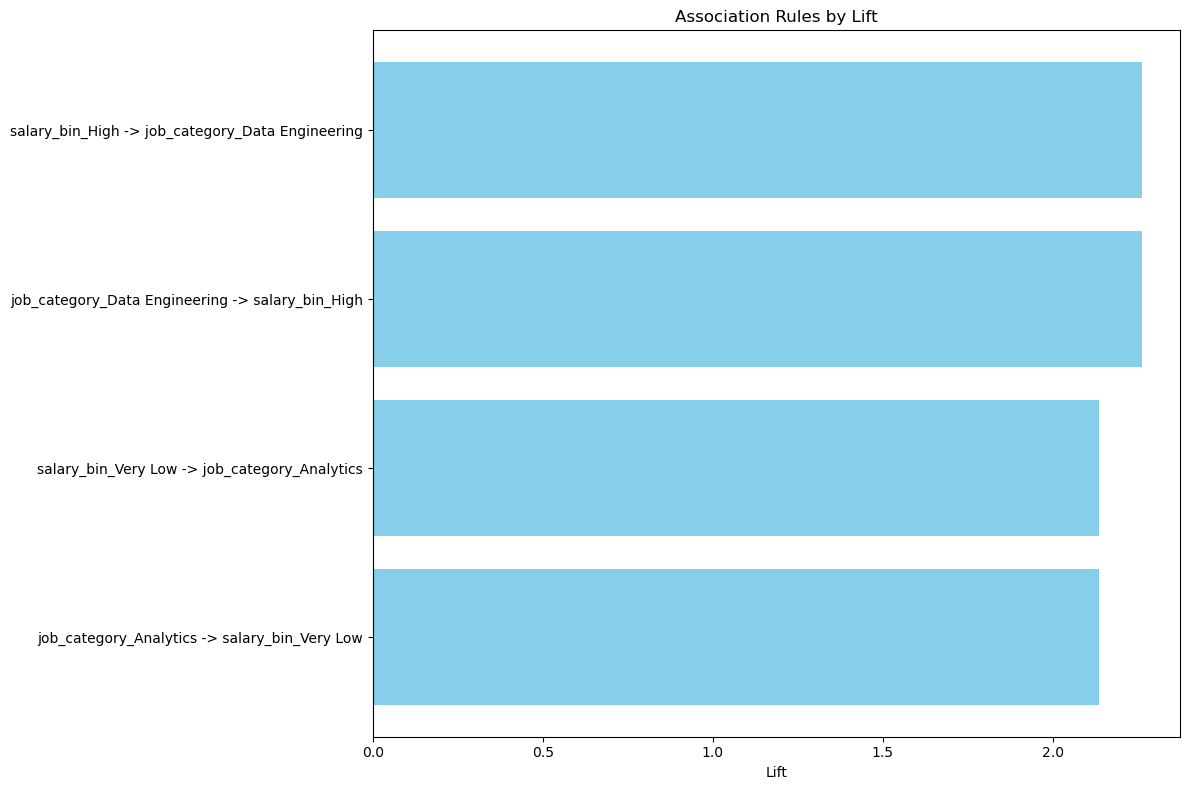

In [54]:
sorted_rules = rules.sort_values('lift', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_rules)), sorted_rules['lift'], color='skyblue')
rule_labels = [f'{list(x)[0]} -> {list(y)[0]}' for x, y in zip(sorted_rules['antecedents'], sorted_rules['consequents'])]

plt.yticks(range(len(sorted_rules)), rule_labels)
plt.xlabel('Lift')
plt.title('Association Rules by Lift')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

After applying association rule mining to the dataset's job categories and salaries, we discovered useful information on the patterns between salary levels and job categories. 

- Individuals in the **`High salary bin`** are most usually linked with **`Data Engineering`**, with a confidence level of **`42.7%`**. **`Data Engineering`** positions are likewise associated with **`High salary`**, with a confidence level of **`42.3%`**.

- Employees in the **`Very Low salary bin`** are substantially more likely to work in **`Analytics`**, with a confidence level of **`58.6%`**. **`Analytics`** roles are also associated with **`Very Low salary`**, with a confidence level of **`55.6%`**.

The bidirectional nature of the association rules indicate the relatively strong mutual relationship between High salary and Data Engineering jobs and a stronger mutual relationship between Very Low salary and Analytics jobs. Overall, the criteria indicate that high pay are more common in data engineering professions, but very low salaries are more frequent in analytics roles.

## Statistical Inference

### Hypothesis Testing

1. Formulating Hypotheses
- **Null Hypothesis (\(H_0\))**: There is no significant difference in the average salaries across different job titles in the data science domain.
- **Alternative Hypothesis (\(H_1\))**: There is a significant difference in the average salaries across different job titles in the data science domain.
- **Significance Level**: 0.05

2. Perform pre-processing to check for the normality of the distribution and if the variances are equal.

In [35]:
# Get unique job titles
job_titles = ds_us_salary_clean['job_title'].unique()

# Check normality using the Shapiro-Wilk test
normality_results = {}
for title in job_titles:
    salaries = ds_us_salary_clean[ds_us_salary_clean['job_title'] == title]['salary_in_usd']
    if len(salaries) >= 3:
        stat, p_value = shapiro(salaries)
        normality_results[title] = (stat, p_value)
    else:
        normality_results[title] = ('Insufficient data', 'Insufficient data')

# Display normality results
print("Normality Test Results (Shapiro-Wilk Test):")
for title, result in normality_results.items():
    print(f'Job Title: {title}, Shapiro-Wilk Test Statistic: {result[0]}, p-value: {result[1]}')

# Check Homogeneity of Variances using Levene's test
salary_data = [ds_us_salary_clean[ds_us_salary_clean['job_title'] == title]['salary_in_usd'] for title in job_titles if len(ds_us_salary_clean[ds_us_salary_clean['job_title'] == title]) >= 3]

if len(salary_data) > 1:
    stat, p_value = levene(*salary_data)

    # Display homogeneity results
    print(f'\nHomogeneity of Variances Test (Levene\'s Test):')
    print(f'Levene Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
else:
    print("\nNot enough groups with sufficient data for Levene's test.")


Normality Test Results (Shapiro-Wilk Test):
Job Title: Machine Learning Engineer, Shapiro-Wilk Test Statistic: 0.9680585861206055, p-value: 1.9453656932455488e-05
Job Title: Applied Scientist, Shapiro-Wilk Test Statistic: 0.9523046612739563, p-value: 0.023236731067299843
Job Title: Data Scientist, Shapiro-Wilk Test Statistic: 0.9692162275314331, p-value: 9.493852926034663e-11
Job Title: Data Analyst, Shapiro-Wilk Test Statistic: 0.9587337970733643, p-value: 5.668180508289211e-11
Job Title: Data Modeler, Shapiro-Wilk Test Statistic: Insufficient data, p-value: Insufficient data
Job Title: Business Intelligence Engineer, Shapiro-Wilk Test Statistic: 0.9891149401664734, p-value: 0.9528908133506775
Job Title: Data Engineer, Shapiro-Wilk Test Statistic: 0.9730939865112305, p-value: 6.437868467490393e-12
Job Title: Computer Vision Engineer, Shapiro-Wilk Test Statistic: 0.95975661277771, p-value: 0.7803489565849304
Job Title: Research Engineer, Shapiro-Wilk Test Statistic: 0.9366337060928345,

* Based on the results it seems that some job titles are not normally distributed and the variances are unequal if the p-values are less than 0.05.

3. Perform Welch ANOVA Test and Kruskal-Wallis H Test

In [36]:
# Perform Welch ANOVA test
if len(salary_data) > 1:
    welch_anova = pg.welch_anova(data=ds_us_salary_clean, dv='salary_in_usd', between='job_title')
    print("\nWelch ANOVA Test:")
    print(welch_anova)
else:
    print("Not enough groups with sufficient data for Welch ANOVA test.")
    
# Perform Kruskal-Wallis H test
if len(salary_data) > 1:
    stat, p_value = kruskal(*salary_data)
    print(f'\nKruskal-Wallis H Test:')
    print(f'Statistic: {stat:.4f}, p-value: {p_value:.4f}')
else:
    print("Not enough groups with sufficient data for Kruskal-Wallis H test.")


Welch ANOVA Test:
      Source  ddof1     ddof2          F         p-unc       np2
0  job_title     60  77.98622  10.981487  5.415243e-21  0.180432

Kruskal-Wallis H Test:
Statistic: 532.0965, p-value: 0.0000


4. Evaluating Results

* Rejecting the Null Hypothesis: Given that p-values for both the Welch ANOVA Test and Kruskal-Wallis H Test is significantly less than the significance level: 0.05 , we reject the null hypothesis.
* There are significant differences in the average salaries across different job titles in the data. This implies that job title has a substantial impact on salary within the dataset.